In [23]:
import pandas as pd
df = pd.read_csv("cardinality_benchmark.tsv", sep="\t")
df

,precision,bits,exact,hll,hll_multiplicity,hash_name
0,4,1,99481,18.064531,18.064531,fasthash::metro::crc::Hasher64_1
1,4,2,99481,86.144000,86.144000,fasthash::metro::crc::Hasher64_1
2,4,3,99481,1378.304000,1378.304000,fasthash::metro::crc::Hasher64_1
3,4,4,99481,106519.490000,106519.490000,fasthash::metro::crc::Hasher64_1
4,4,5,99481,115657.520000,115657.520000,fasthash::metro::crc::Hasher64_1
...,...,...,...,...,...,...
325600,6,5,99506,103908.130000,103907.690000,fasthash::metro::crc::Hasher64_1
325601,6,6,99506,103907.690000,103907.690000,fasthash::metro::crc::Hasher64_1
325602,7,1,99506,149.116350,149.116350,fasthash::metro::crc::Hasher64_1
325603,7,2,99506,732.437000,732.437000,fasthash::metro::crc::Hasher64_1


In [24]:
(df.hll == df.hll_multiplicity).mean()

0.891865911150013

In [25]:
df["memory"] = 2**df.precision * df.bits
df["label"] = "HLL"

In [26]:
df["squared_error_hll"] = (df.exact - df.hll)**2
df["squared_error_hll_multiplicity"] = (df.exact - df.hll_multiplicity)**2
columns = ["squared_error_hll", "squared_error_hll_multiplicity",]
data_hll = df.groupby(["precision", "bits", "memory", "hash_name"])[columns].agg(["mean", "std"])
data_hll = data_hll.reset_index()
data_hll

precision bits  memory                         hash_name  \
                                                               
0           4    1      16  fasthash::metro::crc::Hasher64_1   
1           4    1      16   highway::builder::HighwayHasher   
2           4    1      16       siphasher::sip::SipHasher13   
3           4    1      16       siphasher::sip::SipHasher24   
4           4    2      32  fasthash::metro::crc::Hasher64_1   
..        ...  ...     ...                               ...   
331        17    5  655360       siphasher::sip::SipHasher24   
332        17    6  786432  fasthash::metro::crc::Hasher64_1   
333        17    6  786432   highway::builder::HighwayHasher   
334        17    6  786432       siphasher::sip::SipHasher13   
335        17    6  786432       siphasher::sip::SipHasher24   

    squared_error_hll               squared_error_hll_multiplicity  \
                 mean           std                           mean   
0        9.897197e+09  4.369296e+06                   9.897197e+09   
1        9.897196e+09  4.371501e+06                   9.897196e+09   
2        9.897196e+09  4.371501e+06                   9.897196e+09   
3        9.897196e+09  4.371501e+06                   9.897196e+09   
4        9.883656e+09  4.366306e+06                   9.883656e+09   
..                ...           ...                            ...   
331      4.603483e+04  6.654186e+04                   4.603483e+04   
332      4.690963e+04  6.313286e+04                   4.690963e+04   
333      5.112113e+04  7.325917e+04                   5.112113e+04   
334      5.193246e+04  6.802484e+04                   5.193246e+04   
335      4.603483e+04  6.654186e+04                   4.603483e+04   

                   
              std  
0    4.369296e+06  
1    4.371501e+06  
2    4.371501e+06  
3    4.371501e+06  
4    4.366306e+06  
..            ...  
331  6.654186e+04  
332  6.313286e+04  
333  7.325917e+04  
334  6.802484e+04  
335  6.654186e+04  

[336 rows x 8 columns]

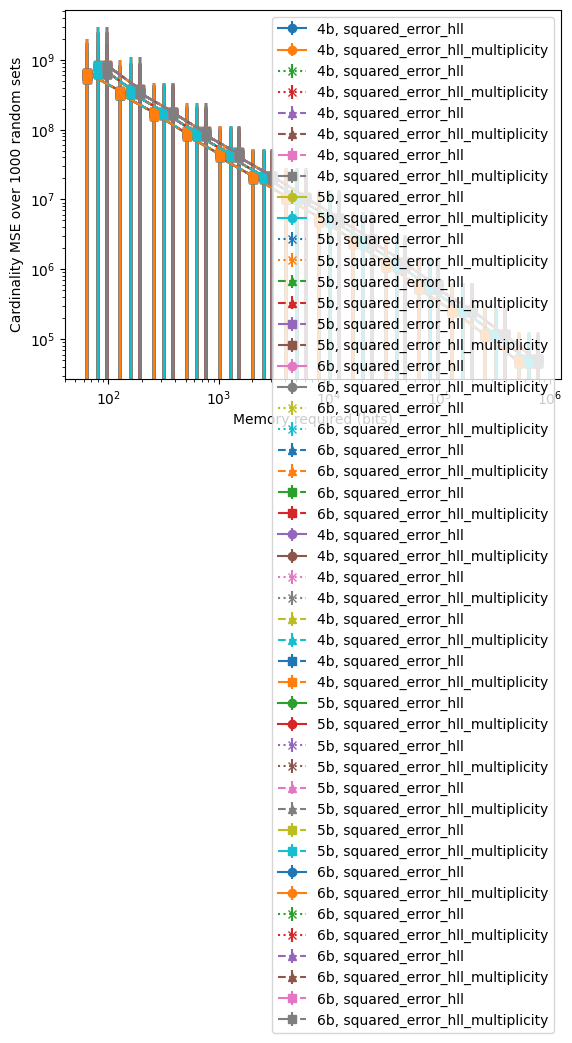

In [27]:
import matplotlib.pyplot as plt

bits_to_skip = (1, 2, 3)

hash_name_line_style = {
    "Hasher64_1": "-",
    "SipHasher13": "--",
    "SipHasher24": "-.",
    "HighwayHasher": ":",
}

hash_name_marker_style = {
    "Hasher64_1": "o",
    "SipHasher13": "^",
    "SipHasher24": "s",
    "HighwayHasher": "x",
}

for column in columns:
    for bits in data_hll["bits"].unique():
        for hash_name in data_hll["hash_name"].unique():
            if bits in bits_to_skip:
                continue
            for column in columns:
                filtered = data_hll[data_hll.bits == bits]
                short_hash_name = hash_name.split(':')[-1]
                plt.errorbar(
                    filtered.memory,
                    filtered[column]["mean"],
                    filtered[column]["std"],
                    linestyle=hash_name_line_style[short_hash_name],
                    marker=hash_name_marker_style[short_hash_name],
                    label=f"{bits}b, {column}"
                )

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Cardinality MSE over 1000 random sets")
plt.xlabel("Memory required (bits)")
plt.show()